## Import libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

2023-06-26 16:12:51.217801: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:12:51.256676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:12:51.257500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 16:12:51.932145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


## Load the dataset

In [3]:
# Load a dataset into a Pandas Dataframe
dataset_train = pd.read_csv('./data/train.csv')
dataset_test = pd.read_csv('./data/test.csv')
print("Full train dataset shape is {}".format(dataset_train.shape))
print(dataset_test.shape)
submission = pd.DataFrame(dataset_test['PassengerId'])
#submission.info

Full train dataset shape is (8693, 14)
(4277, 13)


In [4]:
dataset_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Exploratory Data Analysis

In [5]:
dataset_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: xlabel='Transported'>

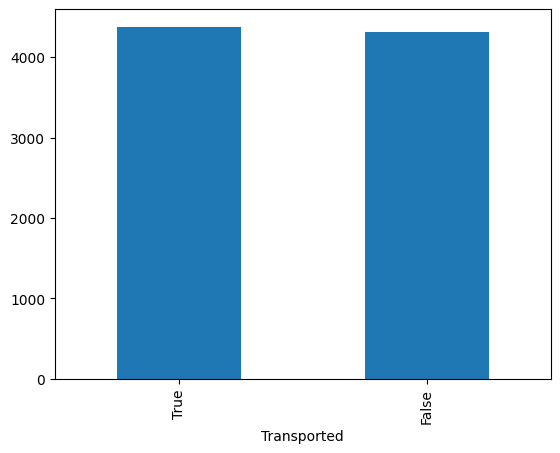

In [7]:
plot_df = dataset_train.Transported.value_counts()
plot_df.plot(kind="bar")

In [8]:
train_df = dataset_train.dropna(thresh=2)
train_df.info()
train_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

<Axes: >

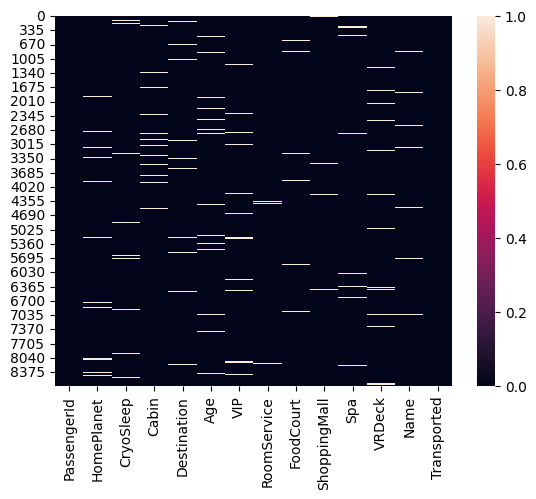

In [9]:
sns.heatmap(train_df.isnull())

In [10]:
# Iterate over categorical features to check their possible categories
for column in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']:
    print(column)
    print(train_df[column].value_counts())
# Only cabin has too many categories to record

HomePlanet
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
CryoSleep
CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Cabin
Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
Destination
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
VIP
VIP
False    8291
True      199
Name: count, dtype: int64


We find out that all missing values appear once in each row

In [11]:
print(train_df.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [12]:
label_df = train_df[['Transported']]
print(train_df.columns)
train_df = train_df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
test_df = dataset_test[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]



Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [13]:

train_df = pd.get_dummies(train_df, prefix=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], drop_first=True)
test_df = pd.get_dummies(test_df, prefix=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], drop_first=True)
train_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,True,False
1,24.0,109.0,9.0,25.0,549.0,44.0,False,False,False,False,True,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,True,False,False,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,True,False,False,False,True,False
4,16.0,303.0,70.0,151.0,565.0,2.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,True,False,False,False,False,True
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,False,True,True,False,False
8690,26.0,0.0,0.0,1872.0,1.0,0.0,False,False,False,False,True,False
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,True,False,False,False,False,False


In [14]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_cols = list(set(train_df.columns) - set(numeric_cols))
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
test_df[numeric_cols] = test_df[numeric_cols].fillna(test_df[numeric_cols].median())

print(train_df.shape)
print(label_df.shape)
print(test_df.shape)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
['CryoSleep_True', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'HomePlanet_Europa', 'HomePlanet_Mars', 'VIP_True']
(8693, 12)
(8693, 1)
(4277, 12)


<Axes: >

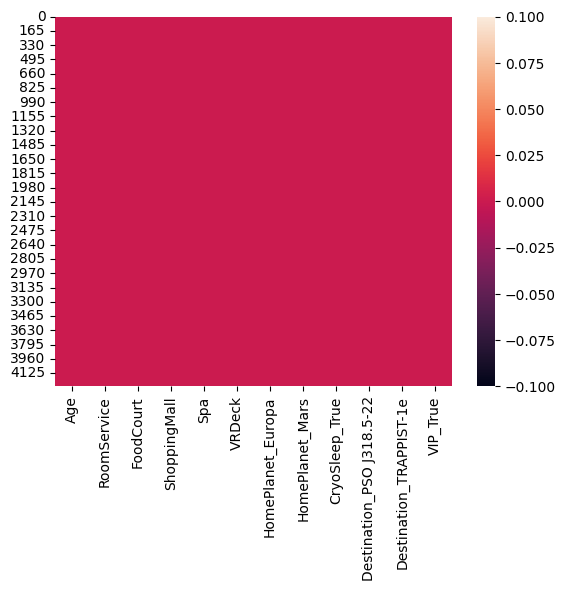

In [15]:
X = train_df
y = label_df
X_test = test_df


#sns.heatmap(X.isnull())
sns.heatmap(X_test.isnull())

In [16]:
X.isna().sum()
X_test.isna().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_True               0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_True                     0
dtype: int64

In [17]:
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.

clf.fit(X, y)
prediction = clf.predict(X_test)
print(prediction)

[ True False  True ...  True  True  True]


/home/justin88lin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/justin88lin/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/justin88lin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [19]:
submission['Transported'] = prediction
print(submission)
submission.to_csv("./logsitic_reg_submission.csv", index = False)

     PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01        False
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]
